In [1]:
import pywikibot
import queue
import gensim
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')  # Suppresses gensim errors
import matplotlib.pyplot as plt
import seaborn as sns

### Things I've installed:
1. wikipedia (query wikipedia) - not used
2. pywikibot (more advanced queries)
3. wikiutils (read sql.gz files) - not yet used. possibly in the future
4. gensim (for NLP and specifically using Google's word2vec)

### Load word2vec embeddings

In [3]:
# Obviously override this to your local location
#model_addr = '/Users/benjaminrafetto/Code/cs182/project/data/GoogleNews-vectors-negative300.bin'

# claire's address 
model_addr = '/Users/clairestolz/CS182/CS182-Final-Project/data/GoogleNews-vectors-negative300.bin'

In [4]:
model = gensim.models.KeyedVectors.load_word2vec_format(model_addr, binary=True)  

### Crude definition of distance

In [5]:
# Currently uses average word distances from word2vec embeddings
def get_distance(topic, model, goal, option="combined"):
    # combined, min, and average
    assert type(topic) is list and type(goal) is list
    try:
        distances = [model.distance(x, y) for x in topic for y in goal]
        if option == "combined":
            return (np.average(distances) + np.min(distances) / 2.0)  # Combination of average and minimum
        elif option == "average":
            return np.average(distances)
        elif option == "minimum":
            return np.min(distances)
        else:
            raise Exception("Invalid distance metric: {}".format(option))
    except:
        return np.Infinity

### Connect to Wikipedia

In [6]:
site = pywikibot.Site("en", "wikipedia")

In [7]:
def greedy_word2vec_path(start, goal, maxIters=30, verbose=False, distance_metric="combined", combine_phrases=True):
    start_list = process_word(start, model, combine_phrases)
    goal_list = process_word(goal, model, combine_phrases)
    assert get_distance(start_list, model, goal_list, distance_metric) is not np.inf, "Start and end nodes {} and {} must be in word2vec vocabulary.".format(start, goal)
    
    start_page = pywikibot.Page(site, start)
    path = []
    visited = []
    fringe = queue.PriorityQueue()
    fringe.put((np.Inf, start_page))
    
    i = 0
    while i < maxIters and not fringe.empty():
        i += 1
        priority, page = fringe.get()
        path.append(page.title())
        if verbose:
            print("Exploring node {} with distance {}".format(page.title(), priority))
        if goal.lower() == page.title().lower():
            return path

        for p in page.linkedPages():
            if p.title() not in visited:
                visited.append(p.title())
                processed = process_word(p.title(), model, combine_phrases)
#                 print(p.title(), processed)
                distance = get_distance(processed, model, goal_list, distance_metric)
                fringe.put((distance, p))

    return []
#     raise Exception("Unable to find goal node.")

In [8]:
def process_word(topic, model=model, combine_phrases=True):
    if not topic:  #No topic. Stop.
        return []
    
    if topic in model:
        return [topic]

    output = []
    words = topic.split(' ')

    if combine_phrases:
        #Iteratively search word2vec for shorter and shorter phrases
        for j in range(len(words), 1, -1):
            test = '_'.join(words[:j])
            if test in model:
                return [test] + process_word(' '.join(words[j:]), model, combine_phrases)

    if words[0] in model:
        output.append(words[0])
    return output + process_word(' '.join(words[1:]), model, combine_phrases)

### Test algorithm

In [9]:
examples = [("speech", "lacrosse"),
            ("mantra", "dna"),
            ("Parthenon", "Natural Environment"),
            ("Feces", "Poet"),
#             ("penguin", "sans-serif"),  #sans-serif is not in the dictionary
            ("angelina jolie", "nitrogen"),
            ("Carrie Fisher", "Death of Adolf Hitler"),
            ("Lacrosse", "Comedian"),
            ("Dictionary", "Atmosphere of Earth"),
            ("Broadway theatre", "Wall Street"),
            ("Life expectancy", "Graphical User Interface"),
            ("Diazepam", "Death"),
            ("Moors", "Aryan"),
            ("Michelangelo", "Horror Fiction"),
            ("Jim Henson", "Gin"),
            ("Continental Army", "Computer Multitasking"),
            ("World Health Organization", "Ecosystem"),
            ("Blood pressure", "Mathematics"),
            ("War of 1812", "Queens of the Stone Age"),
            ("Onomatopoeia", "Wiki"),
            ("Church of England", "Joan Baez"),
            ("Nuclear Power", "Canadians"),
            ("Multi-sport event", "Ku Klux Klan"),
            ("Pony Express", "Augustus"),
            ("Organization", "Parthenon"),
            ("Battleship", "Dream"),
            ("The Cosby Show", "Marine biology"),
            ("DNA replication", "Muscle car"),
            ("Mammal", "Montreal"),
            ("River", "Engine"),
            ("Louis Armstrong", "Nuclear Power"),
            ("Entertainment", "Ralph Waldo Emerson"),
            ("Bilirubin", "Architecture"),
            ("Association football", "Axis powers"),
            ("World Series", "Nuclear warfare"),
            ("Sherlock Holmes","Magnetic resonance imaging"),
            ("Waterboarding","World War II"),
            ("World Trade Organization", "Ant"),
            ("Printed circuit board", "Typhoid fever"),
            ("Statistics","Renaissance"),
            ("Radio","Personal computer"),
            ("Bette Midler","Jellyfish"),
            ("Sigmund Freud","Vacuum"),
            ("Credit card","String theory"),
            ("Radiohead","Magnetic field"),
            ("Biosphere","Nobel Prize in Physiology or Medicine"),
            ("Mick Jagger","Knife"),
            ("West Indies","Gastroesophageal reflux disease"),
            ("Wesley Snipes","Computer science"),
            ("Airline","Bavaria"),
            ("Nevada","Maltose")
           ]

In [10]:
start, goal = examples[np.random.choice(len(examples))]
print("Searching for shortest path from {} to {}".format(start,goal))

Searching for shortest path from World Health Organization to Ecosystem


### To-Do: exclude Wikipedia: Category: Talk:

### Generate data for greedy search:

In [11]:
results = {}
# get path length for 50 samples
path_lengths = []
paths = []
for start, goal in examples:
    print("start: {}, goal: {}".format(start,goal))
    path = greedy_word2vec_path(start, goal, maxIters=50, verbose=False, distance_metric="average", combine_phrases=False)
    paths.append(path)
    path_lengths.append(len(path))
    results[(start, goal)] = path

start: speech, goal: lacrosse
start: mantra, goal: dna


KeyboardInterrupt: 

In [12]:
# pickle.dump(results, open('greedy_words_average.pkl', 'wb'))
results_combined = pickle.load( open( "greedy_phrase_combined.pkl", "rb" ) )
results_average = pickle.load( open( "greedy_phrase_average.pkl", "rb" ) )
results_minimum = pickle.load( open( "greedy_phrase_minimum.pkl", "rb" ) )
results_combined_words = pickle.load( open( "greedy_words_combined.pkl", "rb" ) )
results_minimum_words = pickle.load( open( "greedy_words_minimum.pkl", "rb" ) )
results_average_words = pickle.load( open( "greedy_words_average.pkl", "rb" ) )

# Make sure average doesn't have old values

In [20]:
def plot_results(result_list, label_list, title='Kernel density estimation of path lengths for greedy search', save_to_file=None):
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    num_fail = {}

    for data, label in zip(result_list, label_list):
        lengths = []
        num_fail[label] = 0
        for k, v in data.items():
            if len(v) > 0:
                lengths.append(len(v))
            else:
                num_fail[label]+=1
        sns.distplot(lengths, kde=True, hist=False, label=label, rug=True)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title);  # FYI this semi-colon is magic.
    
    if save_to_file:
        fig.savefig(save_to_file)
    
    return num_fail

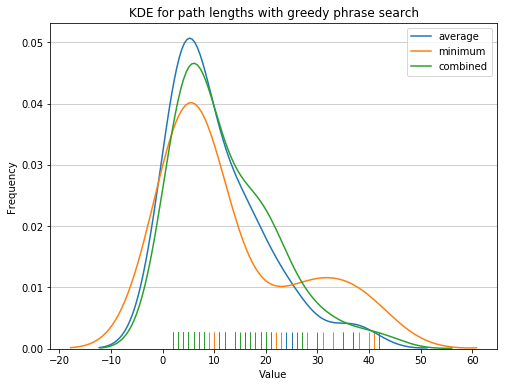

In [21]:
numfail_phrase = plot_results([results_average, results_minimum, results_combined], ['average', 'minimum', 'combined'],
             title="KDE for path lengths with greedy phrase search", save_to_file="kde_phrases.png")

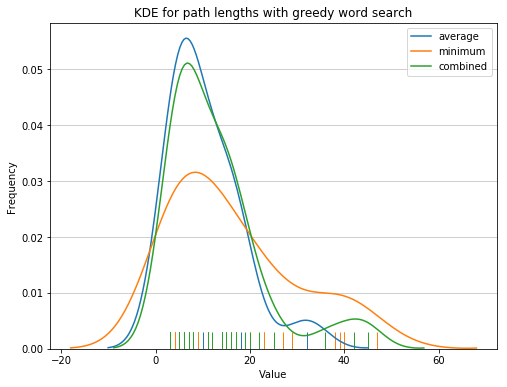

In [22]:
numfail_word = plot_results([results_average_words, results_minimum_words, results_combined_words],
             ['average', 'minimum', 'combined'], title="KDE for path lengths with greedy word search",
             save_to_file="kde_words.png")

In [100]:
display(numfail_word)
display(numfail_phrase)

{'average': 32, 'combined': 11, 'minimum': 19}

{'average': 28, 'combined': 5, 'minimum': 15}

In [80]:
full_data = {'phrase average': 28,'word average': 32,  
              'word minimum': 19,'word combined': 11,'phrase minimum': 15,'phrase combined': 5}
import pandas as pd
df = pd.DataFrame.from_dict(list(full_data.items()))
df.columns = ['algorithm','num_failed']
df

,algorithm,num_failed
0,word average,32
1,phrase minimum,15
2,word minimum,19
3,word combined,11
4,phrase average,28
5,phrase combined,5


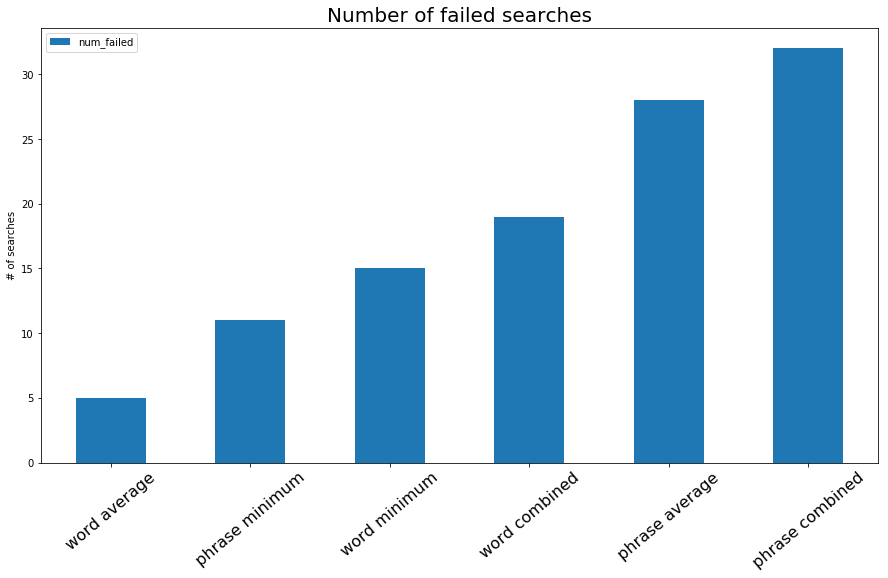

In [98]:

df.sort_values(by='num_failed', ascending=True).plot.bar(stacked=False, figsize=(15,8))
plt.xticks(rotation=40, fontsize=16)
plt.title("Number of failed searches", fontsize=20)
plt.ylabel('# of searches')
plt.xticks(np.arange(6), df['algorithm'])
plt.show()
